## Interactive PACE data checker
**Motivation:** quickly see if you have PACE data available for a determined area and time period.

Let's import some useful packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import panel as pn
import numpy as np
import pandas as pd
import dask.array as da

In [14]:
import warnings
warnings.filterwarnings("ignore")
warnings.warn("ignore")

be sure to type on your teriminal <code>pip install earthaccess</code>.

In [2]:
import earthaccess

In [3]:
auth = earthaccess.login(persist=True)

In [4]:
import datetime as dt
daterange = pn.widgets.DateRangePicker(
    name='Choose your date range:', value=(dt.date(2024,2,1),
                                          dt.date(2024,8,31))
)

text = pn.widgets.TextInput(value='Ready')

menu_items = [('PACE L3', "PACE_OCI_L3M_CHL_NRT"), 
              ('SentinelB L3', "OLCIS3B_L3m_ERR_CHL_NRT")]
menu_button = pn.widgets.MenuButton(name='Chlorophyll Data', items=menu_items, button_type='primary')

def b(event):
    text.value = f"{event.new}"
    
menu_button.on_click(b)

pn.Column(daterange,
          menu_button, text,
          height=200)

Column(height=200)
    [0] DateRangePicker(name='Choose your date range:', value=(datetime.date(2024, ...)
    [1] MenuButton(button_type='primary', items=[('PACE L3', 'PACE_OCI_L3M...], name='Chlorophyll Data')
    [2] TextInput(value='Ready')

In [8]:
tspan = (str(daterange.value[0]), 
         str(daterange.value[1])
) #choose the dates you want to search for PACE data

sname = str(text.value) #getting your data input

In [9]:
if sname == "PACE_OCI_L3M_CHL_NRT":
    granule = "*.DAY.*.0p1deg.*"
    tname = 'PACE'
elif sname == "OLCIS3B_L3m_ERR_CHL_NRT":
    granule = "*.DAY.*.9km.*"
    tname = 'SENTIL 3B'
else:
    print("No satelite data has been chosen!")

In [10]:
results = earthaccess.search_data(
    short_name=sname,#"PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
    granule_name=granule,#"*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="time",
    chunks= {'lat': 100, 'lon': 100}
)

#dataset = dataset.chunk({'time': 10, 'lat': 1000, 'lon': 1000})
dataset.coords

Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0

As Time is not a coordinate, we must assign the date periods so we don't work only with an time index

In [16]:
dataset = dataset.assign_coords(time=pd.date_range(tspan[0], periods=len(dataset.time), freq='D'))
dataset.coords

Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 160B 2024-06-01 2024-06-02 ... 2024-06-20

## Making an interactive plot

Lets plot a Log10(Chlorophyll-a) global map with PACE data

In [29]:
# Definir a projeção
projection = ccrs.PlateCarree()

# Função para criar o plot com base no índice de tempo
def create_plot(time_index):
               
    # Aplicar log10 na variável de clorofila, com Dask
    chlor_a_data = da.log10(dataset['chlor_a'].isel(time=time_index))
    
    # Criar o plot
    clorofila_plot = chlor_a_data.hvplot.quadmesh(
        'lon', 'lat', 
        projection=projection,  # Projeção do Cartopy
        cmap='jet',  # Usar a coloração do cmocean
        rasterize=True,         # Rasterização para melhor desempenho em grandes conjuntos de dados
        coastline=True,         # Adicionar linhas de costa
        geo=True,               # Definir como gráfico geoespacial
        colorbar=True,          # Mostrar colorbar
        title= f'{tname} log10(Chlorophyll-a) [mg/m³] data for {str(dataset.time[time_index].values)[0:10]}'
    )
    
    # Adicionar contorno dos continentes
    clorofila_plot = clorofila_plot.opts(
        width=800,
        height=500
    )
    
    return clorofila_plot

# Definir o intervalo de tempo
time_indexes = np.arange(len(dataset['time']))

# Criar um timepicker
slider = pn.widgets.IntSlider(name='Time index', start=0, end=len(time_indexes)-1, step=1, value=0)

# Criar o painel com o slider e o plot
interactive_plot = pn.bind(create_plot, time_index=slider)

# Layout com o slider na parte superior
layout = pn.Column(slider, interactive_plot)

# Exibir o painel
layout.servable()

Column
    [0] IntSlider(end=19, name='Time index')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [81]:
# Extrair os dados de tempo e concentração de clorofila
def time_series(point):
    time = point['time'].values
    chlor_a = point['chlor_a']#.mean(dim=['lat', 'lon']).values  # Média sobre lat e lon
    
    # Criar o gráfico de barras
    plt.figure(figsize=(8, 4))
    plt.bar(time, chlor_a, color='tab:green')
    
    # Ajustar o formato do eixo x para datas
    plt.gca().xaxis_date()
    
    # Adicionar rótulos e título
    plt.xlabel('')
    plt.ylabel('Chlorophyll-a Concentration [mg/m³]')
    plt.title(f'PACE Chlorophyll-a timeserie for lat: {point.lat.values:.2f} - lon: {point.lon.values:.2f}')
    
    # Rotacionar rótulos do eixo x para melhor visualização
    plt.xticks(rotation=45)
    plt.grid(linestyle='--',alpha=.6)
    
    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

In [83]:
lat_plot = input('Choose your desired Latitude: ')
lon_plot = input('Choose your desired Longitude: ')

point = dataset.sel(lon=lon_plot,lat=lat_plot,method='nearest')

Choose your desired Latitude:  1
Choose your desired Longitude:  -43


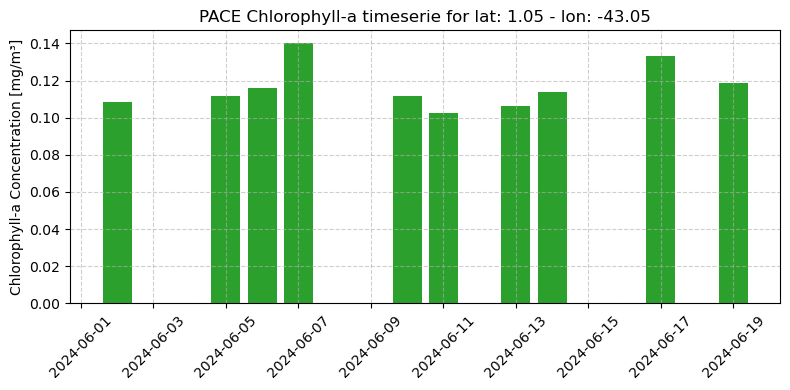

In [84]:
time_series(point)